# Libraries

In [1]:
setwd("~/work/fibroblast_timecourse")

In [2]:
source("R/002_helper_functions.R")

In [3]:
if (!require("pacman")) { install.packages("pacman") }
pacman::p_load(
  data.table,
  GenomicFeatures,
  rtracklayer,
  org.Hs.eg.db,
#   BSgenome.Hsapiens.UCSC.hg38,
  TxDb.Hsapiens.UCSC.hg38.knownGene,
  readr,
  biomaRt,
  MASS,
  liger,
  tidyr,
  dplyr,
  ggplot2,
  seriation,
  hexbin
)

Loading required package: pacman


In [4]:
theme_set(theme_classic(base_size = 18) %+replace% theme(
  strip.background = element_rect(size = 0.3, fill = NA),
  # axis.line.y = element_line(colour = "black", size = 0.2),
  # axis.line.x = element_line(colour = "black", size = 0.2),
  axis.ticks   = element_line(colour = "black", size = 0.3),
  panel.border = element_rect(size = 0.3, fill = NA),
  axis.line    = element_blank(),
  plot.title   = element_text(size = 18, vjust = 2, hjust = 0.5)
))

# Analysis

## Promoters

Get the coordinates of promoters for each gene.

JASPAR is on hg38

ENCODE data is on hg38

In [5]:
txdb        <- TxDb.Hsapiens.UCSC.hg38.knownGene
gene_ranges <- genes(txdb)

gene_ranges$gene_symbol <- mapIds(
  x         = org.Hs.eg.db,
  keys      = gene_ranges$gene_id,
  keytype   = "ENTREZID",
  column    = "SYMBOL",
  multiVals = "first"
)
gene_ranges

prom_upstream   <- 500
prom_downstream <- 250

#prom_ranges <- promoters(gene_ranges, upstream = 500, downstream = 100)
prom_ranges <- promoters(gene_ranges, upstream = prom_upstream, downstream = prom_downstream)

# prom_ranges <- prom_ranges[seqnames(prom_ranges) %in% sprintf("chr%s", c(1:22, "X", "Y"))]

prom_ranges$gene_symbol <- mapIds(
  x         = org.Hs.eg.db,
  keys      = prom_ranges$gene_id,
  keytype   = "ENTREZID",
  column    = "SYMBOL",
  multiVals = "first"
)
prom_ranges

'select()' returned 1:1 mapping between keys and columns


GRanges object with 24183 ranges and 2 metadata columns:
            seqnames                 ranges strand |     gene_id gene_symbol
               <Rle>              <IRanges>  <Rle> | <character> <character>
          1    chr19   [58345178, 58362751]      - |           1        A1BG
         10     chr8   [18391245, 18401218]      + |          10        NAT2
        100    chr20   [44619522, 44651742]      - |         100         ADA
       1000    chr18   [27950966, 28177446]      - |        1000        CDH2
  100009613    chr11   [70072434, 70075433]      - |   100009613    ANO1-AS2
        ...      ...                    ...    ... .         ...         ...
       9991     chr9 [112217716, 112333667]      - |        9991       PTBP3
       9992    chr21 [ 34364024,  34371389]      + |        9992       KCNE2
       9993    chr22 [ 19036282,  19122454]      - |        9993       DGCR2
       9994     chr6 [ 89829894,  89874436]      + |        9994    CASP8AP2
       9997    chr2

'select()' returned 1:1 mapping between keys and columns


GRanges object with 24183 ranges and 2 metadata columns:
            seqnames                 ranges strand |     gene_id gene_symbol
               <Rle>              <IRanges>  <Rle> | <character> <character>
          1    chr19   [58362502, 58363251]      - |           1        A1BG
         10     chr8   [18390745, 18391494]      + |          10        NAT2
        100    chr20   [44651493, 44652242]      - |         100         ADA
       1000    chr18   [28177197, 28177946]      - |        1000        CDH2
  100009613    chr11   [70075184, 70075933]      - |   100009613    ANO1-AS2
        ...      ...                    ...    ... .         ...         ...
       9991     chr9 [112333418, 112334167]      - |        9991       PTBP3
       9992    chr21 [ 34363524,  34364273]      + |        9992       KCNE2
       9993    chr22 [ 19122205,  19122954]      - |        9993       DGCR2
       9994     chr6 [ 89829394,  89830143]      + |        9994    CASP8AP2
       9997    chr2

Promoter sequences:

In [6]:
which(table(prom_ranges$gene_symbol) > 1)

RFLNA 
18051

In [7]:
prom_ranges[which(prom_ranges$gene_symbol == "RFLNA"),]

GRanges object with 2 ranges and 2 metadata columns:
            seqnames                 ranges strand |     gene_id gene_symbol
               <Rle>              <IRanges>  <Rle> | <character> <character>
  100533183    chr12 [123972719, 123973468]      + |   100533183       RFLNA
     144347    chr12 [124288664, 124289413]      + |      144347       RFLNA
  -------
  seqinfo: 455 sequences (1 circular) from hg38 genome

In [8]:
gene_ranges <- gene_ranges[which(gene_ranges$gene_symbol != "RFLNA"),]
prom_ranges <- prom_ranges[which(prom_ranges$gene_symbol != "RFLNA"),]

In [9]:
which(table(prom_ranges$gene_symbol) > 1)

named integer(0)

In [10]:
# Promoter sequences
#
# keys <- c("2", "9")
# select(
#   x = txdb,
#   keys = keys,
#   columns = c("TXID", "TXNAME", "TXCHROM", "TXSTART", "TXEND", "TXSTRAND"),
#   keytype = "GENEID"
# )
# prom <- getPromoterSeq(query = chromosomal.loc, subject = Hsapiens, upstream=1000, downstream=0)

In [11]:
prom_bed <- data.frame(
  seqnames = seqnames(prom_ranges),
  starts   = start(prom_ranges)-1,
  ends     = end(prom_ranges),
  names    = prom_ranges$gene_symbol,
  scores   = 0,
  strands  = strand(prom_ranges)
)

In [12]:
fwrite(x = prom_bed, file = "/data/srlab/external-data/JASPAR/promoters_hg38.bed")

## JASPAR motifs

In [13]:
read_jaspar_bed <- function(file) {
  retval <- data.table::fread(input = sprintf("zcat %s", file), skip = 1)
  colnames(retval) <- c(
    "chrom", "start", "end",
    "motif", "rel_score", "log10p",
    "strand"
  )
#   retval
  GenomicRanges::GRanges(
    seqnames = retval$chrom,
    ranges = IRanges::IRanges(
      start = retval$start,
      end = retval$end
    ),
    motif = retval$motif,
    strand = retval$strand,
    rel_score = retval$rel_score,
    log10p = retval$log10p / 100
  )
}

In [14]:
motif_dict <- c(
  "MA0518.1" = "STAT4",
  "MA0144.2" = "STAT3",
  "MA0640.1" = "ELF3",
  "MA0754.1" = "CUX1",
  "MA0105.4" = "NFKB1",
  "MA0778.1" = "NFKB2",
  "MA0107.1" = "RELA"
)

In [15]:
motif_rds <- "data/jaspar_motifs.rds"
if (file.exists(motif_rds)) {
  motif <- readRDS(motif_rds)
} else {
  motif <- list()
  for (key in names(motif_dict)) {
    time_start <- Sys.time()

    tf_name <- motif_dict[key]
    motif[[tf_name]] <- read_jaspar_bed(
      sprintf("/data/srlab/external-data/JASPAR/UCSC_tracks/2018/hg38/tsv/%s.tsv.gz", key)
    )

    time_elapsed <- Sys.time() - time_start
    print(key)
    print(time_elapsed)
  }
  saveRDS(motif, motif_rds)
}

In [22]:
class(motif)
head(motif)
nrow(motif)

[1] "data.table" "data.frame"

chrom,start,end,strand,name,bin,start2,end2,gene,name2,start3,end3
chr17,34269717,34269730,+,STAT4,2,0,13,CCL7,STAT4,0,13
chr17,34269970,34269983,+,STAT4,2,253,266,CCL7,STAT4,253,266
chr17,34270186,34270199,+,STAT4,2,469,482,CCL7,STAT4,469,482
chr17,34269717,34269727,+,STAT3,1,0,10,CCL7,STAT3,0,10
chr17,34269741,34269751,+,STAT3,1,24,34,CCL7,STAT3,24,34
chr17,34269777,34269787,+,STAT3,1,60,70,CCL7,STAT3,60,70


[1] 196

### JASPAR motifs for CUX1

In [24]:
# hb <- hexbin(x = motif$CUX1$rel_score, y = motif$CUX1$log10p, xbins = 40)

# options(repr.plot.width = 7, repr.plot.height = 7)
# plot(hb)

In [23]:
my_genes <- c(
  "CCL7", "STC1", "MMP3", "CCL8", "G0S2", "CCL20", "NAMPT", "IL6",
  "MFSD2A", "C15orf48", "CXCL6", "ADORA2A", "CXCL3", "CXCL8", "CXCL2", "CXCL1"
)
all(my_genes %in% prom_ranges$gene_symbol)

[1] TRUE

## Find motifs in promoter sequences

In [25]:
dat_motif_rds <- "data/jaspar_motifs.rds"
if (file.exists(dat_motif_rds)) {
  dat_motif <- readRDS(dat_motif_rds)
} else {
  
  dat_motif <- list()

  for (this_gene_symbol in my_genes) {
    # this_gene_symbol <- "CXCL8"

    this_prom <- unique(prom_ranges[prom_ranges$gene_symbol %in% c(this_gene_symbol)])

    # this_gene <- gene_ranges[gene_ranges$gene_symbol %in% c(this_gene_symbol)]

    this_motif <- list()
    for (motif_name in names(motif)) {
      x <- suppressWarnings(findOverlaps(
        query   = this_prom,
        subject = motif[[motif_name]]
      ))
      if (length(subjectHits(x)) > 0) {
        this_motif[[motif_name]] <- motif[[motif_name]][subjectHits(x)]
        this_motif[[motif_name]] <- data.frame(
          chrom = seqnames(this_motif[[motif_name]]),
          start = start(this_motif[[motif_name]]),
          end = end(this_motif[[motif_name]]),
          strand = as.character(strand(this_motif[[motif_name]])),
          name = motif_name
        )
      }
    }

    this_motif[[this_gene_symbol]] <- data.frame(
      chrom = as.character(seqnames(this_prom)),
      start = start(this_prom),
      end = end(this_prom),
      strand = as.character(strand(this_prom)),
      name = paste(as.character(this_prom$gene_symbol), "promoter")
    )

    d <- rbindlist(this_motif)
    d$bin <- disjointBins(IRanges(d$start, d$end))

    d$start2 <- d$start - min(d$start)
    d$end2   <- d$end - min(d$start)

    d$gene <- this_gene_symbol

    dat_motif[[this_gene_symbol]] <- d
  }

  dat_motif <- rbindlist(dat_motif)
  
  saveRDS(dat_motif, dat_motif_rds)
}

In [26]:
mat <- dat_motif %>%
filter(!stringr::str_detect(name, "promoter")) %>%
group_by(gene, name) %>%
summarise(n = length(gene)) %>%
spread(name, n, 0)

mat <- as.data.frame(mat)
rownames(mat) <- mat$gene
mat$gene <- NULL
mat <- as.matrix(mat)

mat <- mat[my_genes,c("CUX1", "STAT3", "STAT4", "ELF3", "RELA", "NFKB1", "NFKB2")]
mat

,CUX1,STAT3,STAT4,ELF3,RELA,NFKB1,NFKB2
CCL7,0,6,3,0,1,1,2
STC1,2,6,4,0,0,0,0
MMP3,3,8,3,0,1,0,0
CCL8,1,5,2,0,0,0,1
G0S2,1,2,2,0,1,0,1
CCL20,1,7,2,1,0,0,2
NAMPT,2,10,2,0,0,1,1
IL6,1,8,2,1,0,0,0
MFSD2A,0,2,2,0,0,0,0
C15orf48,1,0,0,0,1,2,2


In [27]:
dat_motif %>%
filter(stringr::str_detect(name, "promoter"))

chrom,start,end,strand,name,bin,start2,end2,gene,name2,start3,end3
chr17,34269721,34270470,+,CCL7 promoter,3,4,753,CCL7,promoter,4,753
chr8,23854558,23855307,-,STC1 promoter,1,0,749,STC1,promoter,750,1
chr11,102843554,102844303,-,MMP3 promoter,1,0,749,MMP3,promoter,750,1
chr17,34318536,34319285,+,CCL8 promoter,1,0,749,CCL8,promoter,0,749
chr1,209674920,209675669,+,G0S2 promoter,1,0,749,G0S2,promoter,0,749
chr2,227813342,227814091,+,CCL20 promoter,1,0,749,CCL20,promoter,0,749
chr7,106286077,106286826,-,NAMPT promoter,1,0,749,NAMPT,promoter,750,1
chr7,22725384,22726133,+,IL6 promoter,1,0,749,IL6,promoter,0,749
chr1,39954612,39955361,+,MFSD2A promoter,1,0,749,MFSD2A,promoter,0,749
chr15,45430029,45430778,+,C15orf48 promoter,1,0,749,C15orf48,promoter,0,749


In [28]:
dat_motif %>%
filter(gene == "CXCL3" & name %in% c("CUX1", "NFKB1", "STAT3")) %>%
arrange(start, end)

chrom,start,end,strand,name,bin,start2,end2,gene,name2,start3,end3
chr4,74038713,74038723,-,STAT3,2,155,165,CXCL3,STAT3,595,585
chr4,74038757,74038769,-,NFKB1,2,199,211,CXCL3,NFKB1,551,539
chr4,74038763,74038773,-,STAT3,5,205,215,CXCL3,STAT3,545,535
chr4,74038777,74038786,-,CUX1,2,219,228,CXCL3,CUX1,531,522
chr4,74038931,74038941,-,STAT3,3,373,383,CXCL3,STAT3,377,367
chr4,74039080,74039090,-,STAT3,2,522,532,CXCL3,STAT3,228,218
chr4,74039230,74039240,-,STAT3,2,672,682,CXCL3,STAT3,78,68
chr4,74039284,74039294,-,STAT3,2,726,736,CXCL3,STAT3,24,14


In [31]:
library(BSgenome.Hsapiens.UCSC.hg38)

getSeq(BSgenome.Hsapiens.UCSC.hg38, names = "chr4", start = 74038713, end = 74038786, strand = "-")

complement(getSeq(BSgenome.Hsapiens.UCSC.hg38, names = "chr4", start = 74038713, end = 74038786, strand = "-"))

Loading required package: BSgenome
Loading required package: Biostrings
Loading required package: XVector

Attaching package: ‘Biostrings’

The following object is masked from ‘package:base’:

    strsplit



  74-letter "DNAString" instance
seq: GGATCGATCTGGAGCTCCGGGAATTTCCCTGGCCCGGCCGCTCCGGGCTTTCCAGTCTCAACCATGCATAAAAA

  74-letter "DNAString" instance
seq: CCTAGCTAGACCTCGAGGCCCTTAAAGGGACCGGGCCGGCGAGGCCCGAAAGGTCAGAGTTGGTACGTATTTTT

In [32]:
dat_motif$name2 <- as.character(dat_motif$name)
dat_motif$name2[stringr::str_detect(dat_motif$name2, "promoter")] <- "promoter"
dat_motif$name2 <- factor(dat_motif$name2, c("promoter", "RELA", "NFKB1", "NFKB2", "CUX1", "STAT3", "STAT4", "ELF3"))

ix_strand <- dat_motif$strand == "-"
dat_motif$start3 <- dat_motif$start2
dat_motif$end3 <- dat_motif$end2
dat_motif$start3[ix_strand] <- prom_upstream + prom_downstream - dat_motif$start2[ix_strand]
dat_motif$end3[ix_strand] <- prom_upstream + prom_downstream - dat_motif$end2[ix_strand]

In [33]:
levels(dat_motif$name2)

[1] "promoter" "RELA"     "NFKB1"    "NFKB2"    "CUX1"     "STAT3"    "STAT4"   
[8] "ELF3"

In [34]:
dat_motif$gene <- factor(dat_motif$gene, rownames(mat))

name2
 NFKB  CUX1 STAT3 STAT4  ELF3 
    5     3    13     2     2 

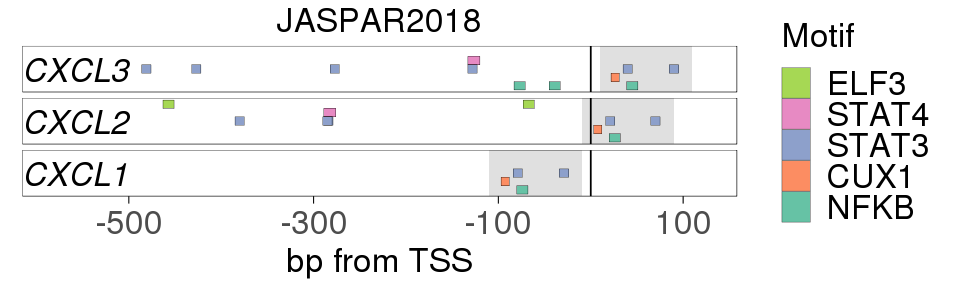

In [194]:
x <- dat_motif %>%
filter(!name2 %in% c("promoter", "RELA", "NFKB1")) %>%
# filter(gene %in% rownames(mat))
# filter(gene %in% c("CXCL1", "CXCL2", "CXCL3", "IL6", "CXCL6", "CXCL8", "C15orf48"))
filter(gene %in% c("CXCL1", "CXCL2", "CXCL3"))

x$name2 <- factor(x$name2)
levels(x$name2)[1] <- "NFKB"

with(x, table(name2))

dat_motif_text <- x %>% filter(!name2 %in% c("promoter")) %>%
select(gene) %>% unique()

options(repr.plot.width = 8, repr.plot.height = 0.5 + nrow(dat_motif_text) * 0.65)

p <- ggplot(x) +
# geom_hline(
#   size = 0.1,
#   yintercept = 1:7 + 0.5,
#   color = "grey80"
# ) +
geom_vline(
  xintercept = prom_upstream,
  size = 0.5,
  color = "black"
) +
geom_rect(
  data = data.frame(
    gene  = c("CXCL1", "CXCL2", "CXCL3"),
    start = c(390, 590, 610),
    end   = c(490, 490, 510)
  ),
  mapping = aes(xmin = start, xmax = end, ymin = -Inf, ymax = Inf),
  fill = "black",
  alpha = 0.12,
  color = NA,
  size = 0
) +
geom_rect(
  mapping = aes(
    xmin = start3, xmax = end3,
    ymin = as.integer(name2), ymax = as.integer(name2) + 1,
    fill = name2
  ),
  color = "black",
  size = 0.1
) +
geom_text(
  size    = 7,
  data    = dat_motif_text,
  mapping = aes(x = -Inf, y = Inf, label = gene),
  hjust   = 0,
  vjust   = 1.5,
  fontface = "italic"
) +
facet_grid(gene ~ .) +
scale_x_continuous(limits = c(-80, max(dat_motif$end3) - 130), labels = function(x) x - prom_upstream) +
# scale_y_continuous(limits = c(2, 9)) +
scale_fill_brewer(palette = "Set2", name = "Motif") +
labs(x = "bp from TSS", y = NULL, title = "JASPAR2018") +
guides(fill = guide_legend(reverse = TRUE)) +
theme(
  legend.title = element_text(size = 20),
  legend.text = element_text(size = 20),
  panel.spacing = unit(0.25, "lines"),
  strip.background = element_blank(),
  strip.text = element_blank(),
  axis.ticks.y = element_blank(),
  axis.text.y = element_blank(),
  axis.text.x = element_text(size = 20),
  axis.title.x = element_text(size = 20),
  plot.title = element_text(size = 20),
  panel.background = element_blank(),
  panel.border = element_rect(size = 0.2)
)

show_plot(p, name = "JASPAR2018")

# Dotplot with seqinr

In [42]:
library("seqinr")


Attaching package: ‘seqinr’

The following object is masked from ‘package:Biostrings’:

    translate

The following object is masked from ‘package:dplyr’:

    count

The following object is masked from ‘package:biomaRt’:

    getSequence



In [195]:
get_gene_seq <- function(this_gene) {
  x <- dat_motif %>%
  filter(stringr::str_detect(name, "promoter"), gene == this_gene) %>%
  as.list
  getSeq(BSgenome.Hsapiens.UCSC.hg38, names = x$chrom, start = x$start, end = x$end, strand = x$strand)
}

In [196]:
dot_matrix <- function(seq1, seq2, wsize = 1, wstep = 1, nmatch = 1) {
  mkwin <- function(seq, wsize, wstep) {
    sapply(
      seq(from = 1, to = length(seq) - wsize + 1, by = wstep), 
      function(i) c2s(seq[i:(i + wsize - 1)])
    )
  }
  wseq1 <- mkwin(seq1, wsize, wstep)
  wseq2 <- mkwin(seq2, wsize, wstep)
  if (nmatch == wsize) {
      xy <- outer(wseq1, wseq2, "==")
  }
  else {
      "%==%" <- function(x, y) colSums(sapply(x, s2c) == sapply(y, 
          s2c)) >= nmatch
      xy <- outer(wseq1, wseq2, "%==%")
  }
  return(xy)
}

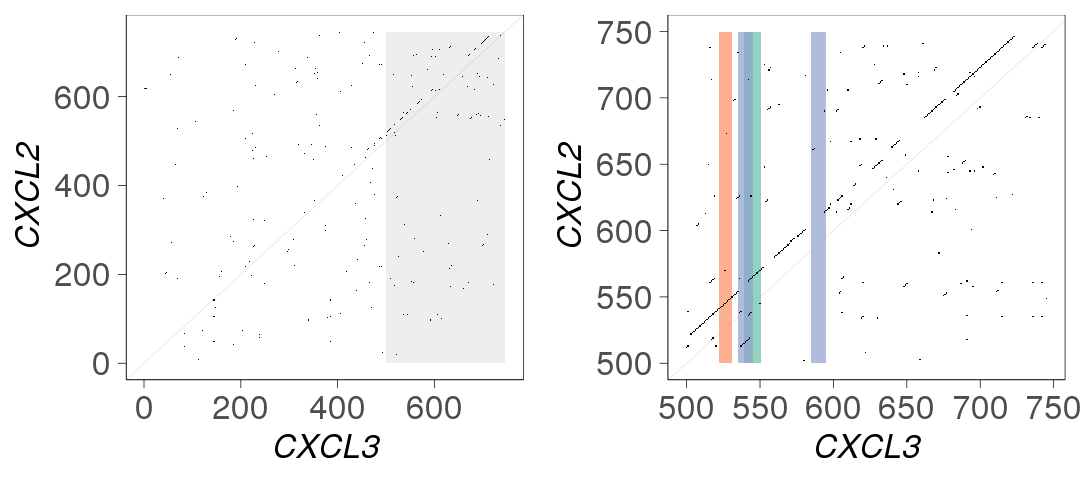

In [203]:
s1 <- get_gene_seq("CXCL3")
s2 <- get_gene_seq("CXCL2")

this_wsize <- 5

m1 <- dot_matrix(
  seq1 = strsplit(as.character(s1), "")[[1]],
  seq2 = strsplit(as.character(s2), "")[[1]],
  wsize = this_wsize, wstep = 1, nmatch = this_wsize
)

d1 <- reshape2::melt(m1)
d1 <- d1[d1$value != 0,]

# d1

options(repr.plot.width = 4.5 * 2, repr.plot.height = 4)

p1 <- ggplot() +
geom_abline(intercept = 0, slope = 1, color = "red", size = 0.1, alpha = 0.3) +
geom_rect(
#   data = dat_motif %>%
#     filter(gene == "CXCL3" & name %in% c("CUX1", "NFKB1", "STAT3") & name == "CUX1") %>%
#     arrange(start, end),
  data = data.frame(xmin = 500, max = max(d1$Var1)),
  mapping = aes(xmin = xmin, xmax = max, ymin = 0, ymax = max),
  alpha = 0.1
) +
geom_raster(
  data = d1,
  mapping = aes(fill = value, x = Var2, y = Var1)
) + 
scale_fill_manual(values = c("black")) +
theme_clean(base_size = 20) +
labs(x = "CXCL3", y = "CXCL2") +
theme(
  legend.position = "none",
  axis.title = element_text(size = 20, face = "italic"),
  axis.text.x = element_text(size = 20),
  axis.text.y = element_text(size = 20),
  plot.title  = element_text(size = 20)
)

p2 <- ggplot() +
geom_abline(intercept = 0, slope = 1, color = "red", size = 0.1, alpha = 0.3) +
geom_rect(
  data = dat_motif %>%
    filter(gene == "CXCL3" & name %in% c("CUX1", "NFKB1", "STAT3") & name == "CUX1") %>%
    arrange(start, end),
  mapping = aes(xmin = start3, xmax = end3, ymin = 500, ymax = 750),
  alpha = 0.7, fill = RColorBrewer::brewer.pal(8, "Set2")[2]
) +
geom_rect(
  data = dat_motif %>%
    filter(gene == "CXCL3" & name %in% c("CUX1", "NFKB1", "STAT3") & name == "NFKB1") %>%
    arrange(start, end),
  mapping = aes(xmin = start3, xmax = end3, ymin = 500, ymax = 750),
  alpha = 0.7, fill = RColorBrewer::brewer.pal(8, "Set2")[1]
) +
geom_rect(
  data = dat_motif %>%
    filter(gene == "CXCL3" & name %in% c("CUX1", "NFKB1", "STAT3") & name == "STAT3") %>%
    arrange(start, end) %>%
    filter(start3 >= 500 & end3 >= 500),
  mapping = aes(xmin = start3, xmax = end3, ymin = 500, ymax = 750),
  alpha = 0.7, fill = RColorBrewer::brewer.pal(8, "Set2")[3]
) +
geom_raster(
  data = d1 %>% filter(Var2 >= 500 & Var1 >= 500),
  mapping = aes(fill = value, x = Var2, y = Var1)
) + 
scale_fill_manual(values = c("black")) +
theme_clean(base_size = 20) +
labs(x = "CXCL3", y = "CXCL2") +
theme(
  legend.position = "none",
  axis.title = element_text(size = 20, face = "italic"),
  axis.text.x = element_text(size = 20),
  axis.text.y = element_text(size = 20),
  plot.title  = element_text(size = 20)
)

show_plot(p1 + p2)

In [207]:
plot_dotplot <- function(g1 = "CXCL3", g2 = "CXCL1") {
  # s1 <- get_gene_seq("CXCL3")
  # s2 <- get_gene_seq("CXCL1")
  s1 <- get_gene_seq(g1)
  s2 <- get_gene_seq(g2)

  this_wsize <- 6

  m1 <- dot_matrix(
    seq1 = strsplit(as.character(s1), "")[[1]],
    seq2 = strsplit(as.character(s2), "")[[1]],
    wsize = this_wsize, wstep = 1, nmatch = this_wsize
  )

  d1 <- reshape2::melt(m1)
  d1 <- d1[d1$value != 0,]

  # d1

  options(repr.plot.width = 4.5 * 2, repr.plot.height = 4)

  zoom_region <- c(400, max(d1$Var1))

  p1 <- ggplot() +
  geom_abline(intercept = 0, slope = 1, color = "red", size = 0.1, alpha = 0.3) +
  geom_rect(
    data = data.frame(xmin = zoom_region[1], max = zoom_region[2]),
    xmin = zoom_region[1], xmax = zoom_region[2],
    ymin = zoom_region[1], ymax = zoom_region[2],
    alpha = 0.1
  ) +
  geom_raster(
    data = d1,
    mapping = aes(fill = value, x = Var2, y = Var1)
  ) + 
  scale_fill_manual(values = c("black")) +
  theme_clean(base_size = 20) +
  labs(x = g1, y = g2) +
  theme(
    legend.position = "none",
    axis.title = element_text(size = 20, face = "italic"),
    axis.text.x = element_text(size = 20),
    axis.text.y = element_text(size = 20),
    plot.title  = element_text(size = 20)
  )

  p2 <- ggplot() +
  geom_abline(intercept = 0, slope = 1, color = "red", size = 0.1, alpha = 0.3) +
  geom_rect(
    data = dat_motif %>%
      filter(gene == g1 & name == "CUX1") %>%
      arrange(start, end),
    mapping = aes(xmin = start3, xmax = end3), ymin = zoom_region[1], ymax = zoom_region[2],
    alpha = 0.7, fill = RColorBrewer::brewer.pal(8, "Set2")[2]
  ) +
  geom_rect(
    data = dat_motif %>%
      filter(gene == g1 & name == "NFKB1") %>%
      arrange(start, end),
    mapping = aes(xmin = start3, xmax = end3), ymin = zoom_region[1], ymax = zoom_region[2],
    alpha = 0.7, fill = RColorBrewer::brewer.pal(8, "Set2")[1]
  ) +
  geom_rect(
    data = dat_motif %>%
      filter(gene == g1 & name == "STAT3") %>%
      arrange(start, end) %>%
      filter(start3 >= zoom_region[1] & end3 >= zoom_region[1]),
    mapping = aes(xmin = start3, xmax = end3), ymin = zoom_region[1], ymax = zoom_region[2],
    alpha = 0.7, fill = RColorBrewer::brewer.pal(8, "Set2")[3]
  ) +
  geom_raster(
    data = d1 %>% filter(Var2 >= zoom_region[1] & Var1 >= zoom_region[1]),
    mapping = aes(fill = value, x = Var2, y = Var1)
  ) + 
  scale_fill_manual(values = c("black")) +
  theme_clean(base_size = 20) +
  labs(x = g1, y = g2) +
  theme(
    legend.position = "none",
    axis.title = element_text(size = 20, face = "italic"),
    axis.text.x = element_text(size = 20),
    axis.text.y = element_text(size = 20),
    plot.title  = element_text(size = 20)
  )

  show_plot(p1 + p2)
}


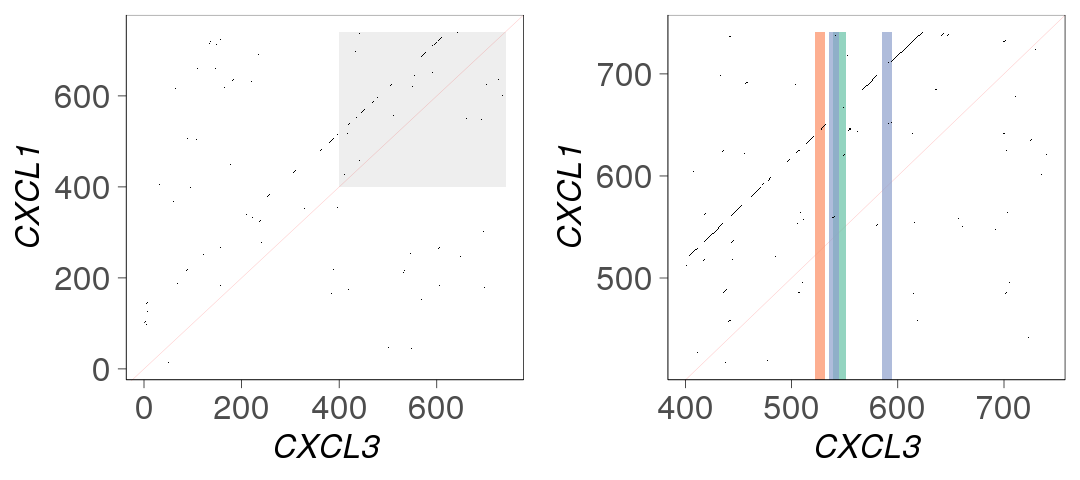

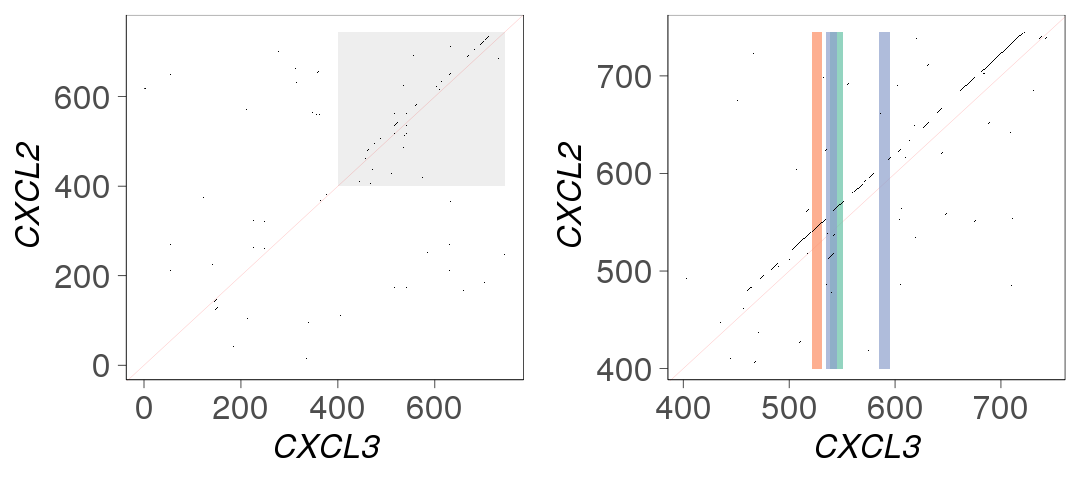

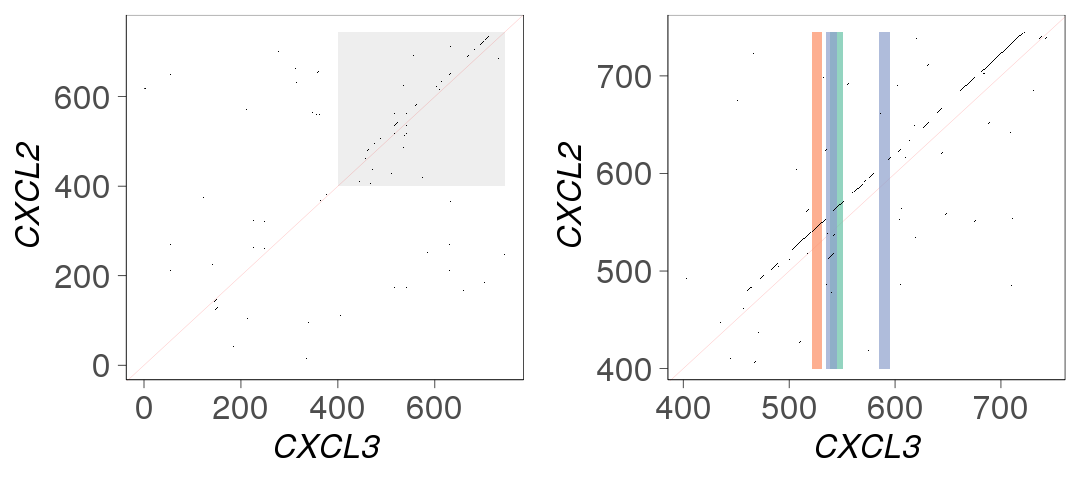

In [210]:
# c(390, 590, 610)
plot_dotplot("CXCL3", "CXCL1")
plot_dotplot("CXCL3", "CXCL2")
plot_dotplot("CXCL3", "CXCL2")

In [193]:
dat_motif %>%
    filter(gene == "CXCL1" & name %in% c("CUX1", "NFKB1", "STAT3") & name == "CUX1") %>%
    arrange(start, end)

chrom,start,end,strand,name,bin,start2,end2,gene,name2,start3,end3
chr4,73869296,73869305,+,CUX1,2,403,412,CXCL1,CUX1,403,412


In [126]:
library(patchwork)

chrom,start,end,strand,name,bin,start2,end2,gene,name2,start3,end3
chr4,74038713,74038723,-,STAT3,2,155,165,CXCL3,STAT3,595,585
chr4,74038757,74038769,-,NFKB1,2,199,211,CXCL3,NFKB1,551,539
chr4,74038763,74038773,-,STAT3,5,205,215,CXCL3,STAT3,545,535
chr4,74038777,74038786,-,CUX1,2,219,228,CXCL3,CUX1,531,522
chr4,74038931,74038941,-,STAT3,3,373,383,CXCL3,STAT3,377,367
chr4,74039080,74039090,-,STAT3,2,522,532,CXCL3,STAT3,228,218
chr4,74039230,74039240,-,STAT3,2,672,682,CXCL3,STAT3,78,68
chr4,74039284,74039294,-,STAT3,2,726,736,CXCL3,STAT3,24,14


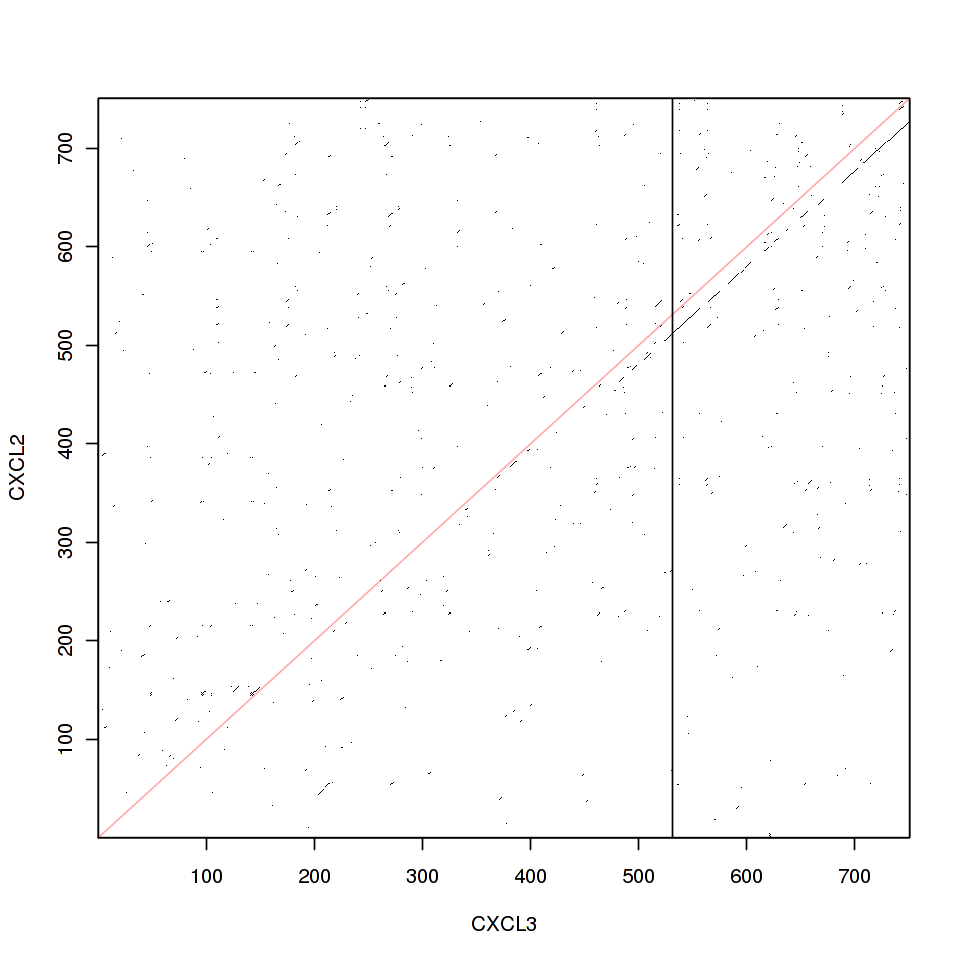

In [76]:
# CXCL3
# "chr4	74038558	74039307"

get_gene_seq <- function(this_gene) {
  x <- dat_motif %>%
  filter(stringr::str_detect(name, "promoter"), gene == this_gene) %>%
  as.list
  getSeq(BSgenome.Hsapiens.UCSC.hg38, names = x$chrom, start = x$start, end = x$end, strand = x$strand)
}

s1 <- get_gene_seq("CXCL3")
s2 <- get_gene_seq("CXCL2")


options(repr.plot.width = 8, repr.plot.height = 8)


dotPlot(
  seq1 = strsplit(as.character(s1), "")[[1]],
  seq2 = strsplit(as.character(s2), "")[[1]],
  wsize = 5, wstep = 1, nmatch = 5,
  xlab = "CXCL3",
  ylab = "CXCL2"
)
abline(0, 1, col = '#ff000055')
abline(
  v = (
    dat_motif %>%
    filter(gene == "CXCL3" & name %in% c("CUX1", "NFKB1", "STAT3") & name == "CUX1") %>%
    arrange(start, end) %>%
    as.list
  )$start3
)

dat_motif %>%
filter(gene == "CXCL3" & name %in% c("CUX1", "NFKB1", "STAT3")) %>%
arrange(start, end)

# getSeq(BSgenome.Hsapiens.UCSC.hg38, names = "chr4", start = 74038713, end = 74038786, strand = "-")

# complement(getSeq(BSgenome.Hsapiens.UCSC.hg38, names = "chr4", start = 74038713, end = 74038786, strand = "-"))

[1] 74038777

### T-Coffee

Consider a multiple sequence alignment:

https://www.ebi.ac.uk/Tools/msa/tcoffee/

In [77]:
dat_motif %>%
#filter(name == "CXCL3 promoter")
filter(stringr::str_detect(name, "promoter")) %>%
filter(chrom == "chr4") %>%
arrange(start)

chrom,start,end,strand,name,bin,start2,end2,gene,name2,start3,end3
chr4,73740006,73740755,+,CXCL8 promoter,1,0,749,CXCL8,promoter,0,749
chr4,73835997,73836746,+,CXCL6 promoter,1,0,749,CXCL6,promoter,0,749
chr4,73868893,73869642,+,CXCL1 promoter,1,0,749,CXCL1,promoter,0,749
chr4,74038558,74039307,-,CXCL3 promoter,1,0,749,CXCL3,promoter,750,1
chr4,74099044,74099793,-,CXCL2 promoter,1,0,749,CXCL2,promoter,750,1


In [78]:
sprintf("chr4:%s-%s", 74038558 + 140, 74038558 + 240)

[1] "chr4:74038698-74038798"

```
   ACTIONS      QUERY           SCORE START  END QSIZE IDENTITY CHRO STRAND  START    END      SPAN
---------------------------------------------------------------------------------------------------
browser details hg38_dna         101     1   101   101 100.0%     4   +   74038698  74038798    101  CXCL3 promoter
browser details hg38_dna          82     2   101   101  91.0%     4   -   73869284  73869383    100  CXCL1 promoter
browser details hg38_dna          76     6    94   101  91.9%     4   +   74099209  74099296     88  CXCL2 promoter
browser details hg38_dna          59     1    81   101  86.5%     4   +   73944420  73944500     81  CXCL1P1 promoter
```

```
>hg38_dna range=chr4:74038698-74038798 5'pad=0 3'pad=0 strand=+ repeatMasking=none
AAGATCGGCGAACCCTTTTTATGCATGGTTGAGACTGGAAAGCCCGGAGC
GGCCGGGCCAGGGAAATTCCCGGAGCTCCAGATCGATCCGGAGTCCCGAA
G
```

# motifmatchr on CXCL3 promoter sequence

In [80]:
library(JASPAR2018)
library(motifmatchr)
library(GenomicRanges)
library(TFBSTools)

In [81]:
print(motif_dict)

MA0518.1 MA0144.2 MA0640.1 MA0754.1 MA0105.4 MA0778.1 MA0107.1 
 "STAT4"  "STAT3"   "ELF3"   "CUX1"  "NFKB1"  "NFKB2"   "RELA" 


In [82]:
opts <- list(species = 9606, name = c("CUX1", "STAT3", "NFKB1", "ELF3", "STAT1"))
PFMatrixList <- getMatrixSet(JASPAR2018, opts)
PFMatrixList

PFMatrixList of length 5
names(5): MA0137.3 MA0144.2 MA0640.1 MA0754.1 MA0105.4

In [83]:
# Make a set of peaks
regions <- GRanges(
  seqnames = c("chr4", "chr4", "chr4", "chr4"),
  ranges = IRanges(
    start = c(74038698, 73869284, 74099205, 73944420),
    end   = c(74038798, 73869383, 74099303, 73944520)
  )
)

# Get motif matches for example motifs in peaks
motif_ix <- matchMotifs(PFMatrixList, regions, genome = "hg38", p.cutoff = 0.005, out = "scores") 

motifMatches(motif_ix)

motifScores(motif_ix)

motifCounts(motif_ix)


Attaching package: ‘Biostrings’

The following object is masked from ‘package:base’:

    strsplit



4 x 5 sparse Matrix of class "lgCMatrix"
     MA0137.3 MA0144.2 MA0640.1 MA0754.1 MA0105.4
[1,]        |        |        |        |        |
[2,]        |        |        |        |        |
[3,]        |        |        |        |        |
[4,]        |        |        .        |        |

4 x 5 sparse Matrix of class "dgCMatrix"
     MA0137.3  MA0144.2  MA0640.1 MA0754.1  MA0105.4
[1,] 9.541955 3.6040778 -4.924036 9.868329  9.496414
[2,] 7.935174 0.3447297 -4.924036 9.868329  9.496414
[3,] 9.541955 0.3447297 -4.924036 9.868329  9.496414
[4,] 4.626961 0.3394320  .        3.099821 -3.089536

4 x 5 sparse Matrix of class "dgCMatrix"
     MA0137.3 MA0144.2 MA0640.1 MA0754.1 MA0105.4
[1,]        1        3        1        2        3
[2,]        1        3        1        2        3
[3,]        1        3        1        2        6
[4,]        1        3        .        2        4

# CXCL3 TSS

In [94]:
library(ggplot2)

In [95]:
print("hi")

[1] "hi"


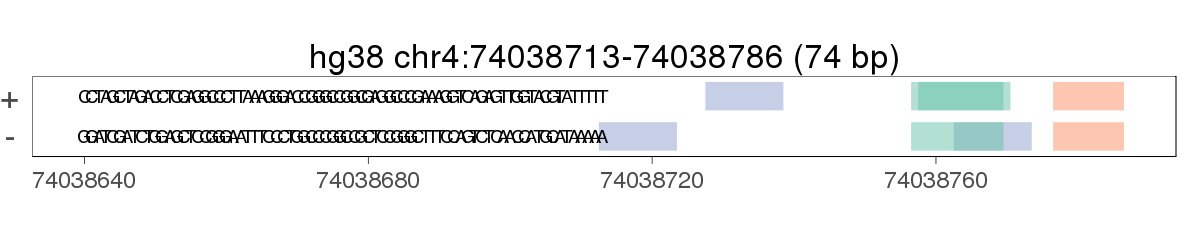

In [146]:
# CXCL3 transcription start site

pwms <- getMatrixSet(JASPAR2018, list(species = 9606, name = c("CUX1", "NFKB1", "STAT3")))

motif_ix <- matchMotifs(pwms, regions[1], genome = "hg38", p.cutoff = 0.005, out = "positions") 

d <- do.call(rbind, lapply(names(motif_ix), function(motif_name) {
  retval <- as.data.frame(motif_ix[[motif_name]])
  if (nrow(retval) > 0) {
    retval[["motif"]] <- motif_name
    if (motif_name %in% names(motif_dict)) {
      retval[["protein"]] <- motif_dict[[motif_name]]
    } else {
      retval[["protein"]] <- "STAT1"
    }
    retval
  }
}))
d$index <- seq(nrow(d))

options(repr.plot.width = 10, repr.plot.height = 2)

d$proteini <- as.integer(factor(d$protein))

dtext <- data.frame(
  pos = unlist(strsplit("TTTTTATGCATGGTTGAGACTGGAAAGCCCGGAGCGGCCGGGCCAGGGAAATTCCCGGAGCTCCAGATCGATCC", "")),
  neg = unlist(strsplit("AAAAATACGTACCAACTCTGACCTTTCGGGCCTCGCCGGCCCGGTCCCTTTAAGGGCCTCGAGGTCTAGCTAGG", ""))
)
dtext$x <- seq(from = 74038713, to = 1 + 74038713 - nrow(dtext))

d$y <- ifelse(d$strand == "+", 1, 0)

p <- ggplot() +
geom_segment(
  data = d,
  aes(x = start - 0.5, xend = end + 0.5, y = y, yend = y, color = protein),
  size = 8, alpha = 0.5
) +
geom_text(
  data = dtext,
  mapping = aes(x = x, y = 1, label = pos),
  hjust = 0.5
) +
geom_text(
  data = dtext,
  mapping = aes(x = x, y = 0, label = neg),
  hjust = 0.5
) +
# geom_segment(
#   data = data.frame(x = 74038773, xend = 74038773, y = 1.5, yend = 1.2),
#   mapping = aes(x, y, xend = xend, yend = yend), arrow = arrow(length = unit(2, "mm")),
#   size = 0.5
# ) +
scale_y_continuous(
  expand = c(0.5, 0),
  breaks = c(0, 1),
  labels = c('0' = "-", '1' = "+")
) +
# scale_x_reverse(
#   breaks = round(seq(min(d$start), max(d$end), by = 10)) - 6,
#   labels = round(max(d$end) - seq(min(d$start), max(d$end), by = 10)) + 7,
#   expand = c(0, 0.3)
# ) +
# scale_color_brewer(palette = "Set2", name = "Motif") +
scale_color_manual(
  guide = FALSE,
  name = "Motif",
  values = c(
    "NFKB1" = "#66C2A5", "CUX1" = "#FC8D62", "STAT3" = "#8DA0CB"
  )
) +
# guides(color = guide_legend(title = "Motif")) +
# theme_void() +
theme(
  axis.line.y = element_blank(),
  axis.ticks.y = element_blank(),
  axis.line.x = element_line(size = 0.2),
  axis.ticks = element_line(size = 0.2),
  axis.text.y = element_text(size = 20, hjust = 0.5),
#   axis.text.x = element_text(size = 20),
  plot.title = element_text(size = 20, hjust = 0.5),
  legend.title = element_text(size = 20),
  legend.text = element_text(size = 20),
  plot.margin = margin(t = 2, b = 2, l = 0, r = 1, unit = "lines")
) +
labs(
  title = sprintf("hg38 chr4:74038713-74038786 (%s bp)", length(dtext$pos)),
  x = NULL,
  y = NULL
)

show_plot(p, name = "CXCL3-promoter")

[1] 74

In [203]:
dput(RColorBrewer::brewer.pal(name = "Set2", n = 8))

c("#66C2A5", "#FC8D62", "#8DA0CB", "#E78AC3", "#A6D854", "#FFD92F", 
"#E5C494", "#B3B3B3")


In [117]:
sprintf("chr4:%s-%s", min(c(d$end, d$start)), max(c(d$start, d$end)))

[1] "chr4:74038713-74038786"

In [123]:
getSeq(BSgenome.Hsapiens.UCSC.hg38, names = "chr4", start = 74038713, end = 74038786, strand = "+")

  74-letter "DNAString" instance
seq: TTTTTATGCATGGTTGAGACTGGAAAGCCCGGAGCGGCCGGGCCAGGGAAATTCCCGGAGCTCCAGATCGATCC

---

## CUX1 ChIP-seq

### ENCODE narrowPeak: Narrow (or Point-Source) Peaks format

This format is used to provide called peaks of signal enrichment based on pooled, normalized (interpreted) data. It is a BED6+4 format.

1. **chrom** - Name of the chromosome (or contig, scaffold, etc.).
2. **chromStart** - The starting position of the feature in the chromosome or scaffold. The first base in a chromosome is numbered 0.
3. **chromEnd** - The ending position of the feature in the chromosome or scaffold. The chromEnd base is not included in the display of the feature. For example, the first 100 bases of a chromosome are defined as chromStart=0, chromEnd=100, and span the bases numbered 0-99.
4. **name** - Name given to a region (preferably unique). Use "." if no name is assigned.
5. **score** - Indicates how dark the peak will be displayed in the browser (0-1000). If all scores were "'0"' when the data were submitted to the DCC, the DCC assigned scores 1-1000 based on signal value. Ideally the average signalValue per base spread is between 100-1000.
6. **strand** - +/- to denote strand or orientation (whenever applicable). Use "." if no orientation is assigned.
7. **signalValue** - Measurement of overall (usually, average) enrichment for the region.
8. **pValue** - Measurement of statistical significance (-log10). Use -1 if no pValue is assigned.
9. **qValue** - Measurement of statistical significance using false discovery rate (-log10). Use -1 if no qValue is assigned.
10. **peak** - Point-source called for this peak; 0-based offset from chromStart. Use -1 if no point-source called.

In [29]:
Sys.glob("data-raw/public-data/ENCODE/CUX1/ENCFF*.bed.gz")

[1] "data-raw/public-data/ENCODE/CUX1/ENCFF000YHL.bed.gz"
[2] "data-raw/public-data/ENCODE/CUX1/ENCFF001VMG.bed.gz"
[3] "data-raw/public-data/ENCODE/CUX1/ENCFF022FYX.bed.gz"
[4] "data-raw/public-data/ENCODE/CUX1/ENCFF688YAV.bed.gz"
[5] "data-raw/public-data/ENCODE/CUX1/ENCFF903AOD.bed.gz"

Download the ENCODE ChIP-seq peaks for CUX1:

In [30]:
cux1_files <- list(
  c(
    experiment = "https://www.encodeproject.org/experiments/ENCSR000EFO/",
    celltype   = "K562 cell line",
    url        = "https://www.encodeproject.org/files/ENCFF688YAV/@@download/ENCFF688YAV.bed.gz"
  ),
  c(
    experiment = "https://www.encodeproject.org/experiments/ENCSR017CEO/",
    celltype   = "MCF-7 cell line",
    url        = "https://www.encodeproject.org/files/ENCFF022FYX/@@download/ENCFF022FYX.bed.gz"
  ),
  c(
    experiment = "https://www.encodeproject.org/experiments/ENCSR000DYR/",
    celltype   = "GM12878 cell line",
    url        = "https://www.encodeproject.org/files/ENCFF903AOD/@@download/ENCFF903AOD.bed.gz"
  )
)
for (cux1_file in cux1_files) {
  bedfile <- basename(cux1_file['url'])
  destfile <- file.path("data-raw/public-data/ENCODE/CUX1", bedfile)
  if (!file.exists(destfile)) {
    download.file(url = cux1_file['url'], destfile = destfile)
  }
}

In [31]:
bed_files <- file.path(
  "data-raw/public-data/ENCODE/CUX1", basename(sapply(cux1_files, "[", "url"))
)
bed_files

cux1_peaks <- do.call("c", GRangesList(lapply(bed_files, function(file) {
  retval <- read_encode_bed(file)
  retval$file <- basename(file)
  retval[seqnames(retval) %in% sprintf("chr%s", c(1:22, "X", "Y"))]
})))

cux1_peaks

[1] "data-raw/public-data/ENCODE/CUX1/ENCFF688YAV.bed.gz"
[2] "data-raw/public-data/ENCODE/CUX1/ENCFF022FYX.bed.gz"
[3] "data-raw/public-data/ENCODE/CUX1/ENCFF903AOD.bed.gz"

GRanges object with 899086 ranges and 5 metadata columns:
    seqnames                 ranges strand |     score signalValue    pValue
       <Rle>              <IRanges>  <Rle> | <integer>   <numeric> <numeric>
  .     chr7 [ 67019686,  67019976]      * |         0    349.1455        -1
  .     chr7 [148987056, 148987379]      * |         0    341.0758        -1
  .     chr2 [ 11279348,  11279620]      * |         0    318.0502        -1
  .     chr2 [ 62177419,  62177763]      * |         0    305.2414        -1
  .    chr15 [ 35557630,  35557886]      * |         0    295.4011        -1
  .      ...                    ...    ... .       ...         ...       ...
  .     chr4 [147855744, 147856120]      * |         0    8.066585        -1
  .     chr5 [116463275, 116463651]      * |         0    8.066585        -1
  .     chr6 [  3235967,   3236343]      * |         0    8.066585        -1
  .     chr7 [ 97064923,  97065299]      * |         0    8.066585        -1
  .     chr8 [ 142

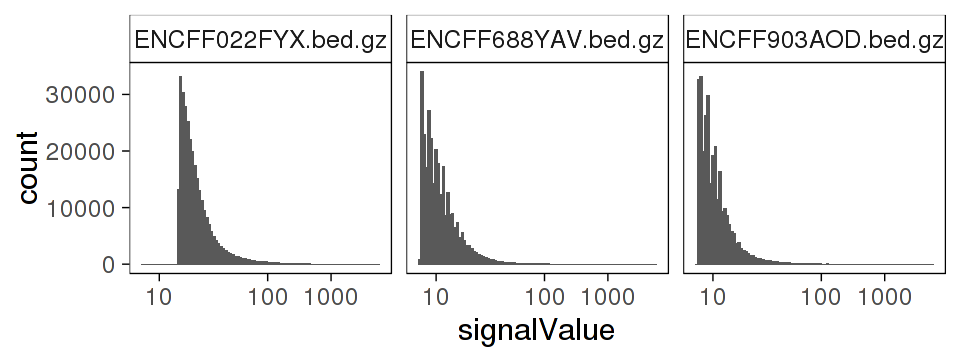

In [37]:
options(repr.plot.width = 8, repr.plot.height = 3)

data.frame(
  signalValue = log10(cux1_peaks$signalValue),
  file = cux1_peaks$file
) %>%
ggplot(aes(x = signalValue)) +
geom_histogram(bins = 100) +
facet_grid(~ file) +
scale_x_log10(labels = function(x) 10^x)

Choose the peaks with `signalValue` greater than the 0.9 quantile:

In [39]:
d <- with(cux1_peaks, data.frame(
#   gene_symbol = gene_symbol,
  signalValue = signalValue,
  file = file
)) %>%
group_by(file) %>%
mutate(include = signalValue > quantile(signalValue, probs = 0.9))
table(d$include, d$file)

       
        ENCFF022FYX.bed.gz ENCFF688YAV.bed.gz ENCFF903AOD.bed.gz
  FALSE             269577             269892             269708
  TRUE               29953              29988              29968

Promoters with a CUX1 peak:

In [41]:
f1 <- suppressWarnings(findOverlaps(
#   query = cux1_peaks[d$include,],
  query = cux1_peaks,
  subject = prom_ranges
))
prom_hits <- prom_ranges[subjectHits(f1)]
prom_hits$file <- cux1_peaks[queryHits(f1)]$file
prom_hits

length(unique(prom_hits$gene_symbol))

GRanges object with 30225 ranges and 3 metadata columns:
            seqnames                 ranges strand |     gene_id gene_symbol
               <Rle>              <IRanges>  <Rle> | <character> <character>
  102723099     chr7 [148987027, 148987626]      + |   102723099       GHET1
       6084     chr7 [148987149, 148987748]      - |        6084        RNY1
       4211     chr2 [ 66432952,  66433551]      + |        4211       MEIS1
     730198     chr2 [ 66433371,  66433970]      - |      730198   MEIS1-AS3
       8341     chr6 [ 27837260,  27837859]      + |        8341   HIST1H2BN
        ...      ...                    ...    ... .         ...         ...
     340512     chr9 [107102889, 107103488]      - |      340512   LOC340512
      58506    chr19 [ 49641625,  49642224]      + |       58506       SCAF1
       4647    chr11 [ 77127764,  77128363]      + |        4647       MYO7A
     162972    chr19 [ 57559764,  57560363]      - |      162972      ZNF550
      51315     chr

[1] 14509

Considering a few genes of interest, which of them have a CUX1 peak in the promoter?

In [59]:
these_genes <- c(
  "CXCL1", "CXCL2", "CXCL3",
  "CXCL5", "CXCL6", "CXCL8",
  "CXCL10", "CCL20", "CCL5",
  "CCL2", "IL6", "CSF2",
  "CSF3", "NFKBIZ", "ELF3",
  "IL23A", "PTGS2", "G0S2",
  "MMP3", "MMP1", "TNFAIP2",
  "TNFAIP6"
)

print(sort(unique(
  prom_hits[prom_hits$gene_symbol %in% these_genes]$gene_symbol
)))

 [1] "CSF2"   "CXCL1"  "CXCL10" "CXCL2"  "CXCL3"  "CXCL8"  "ELF3"   "G0S2"  
 [9] "IL23A"  "IL6"    "NFKBIZ" "PTGS2" 


It looks like the ChIP-seq data on the K562 cell line has peaks in most of our promoters of interest:

In [60]:
x <- table(prom_hits$gene_symbol, prom_hits$file)
x[intersect(rownames(x), these_genes),]
# cux1_genes <- names(which(x == 3))
# these_genes[which(these_genes %in% cux1_genes)]

        
         ENCFF022FYX.bed.gz ENCFF688YAV.bed.gz ENCFF903AOD.bed.gz
  CSF2                    0                  1                  0
  CXCL1                   0                  1                  0
  CXCL10                  1                  0                  0
  CXCL2                   2                  1                  0
  CXCL3                   0                  2                  1
  CXCL8                   0                  1                  0
  ELF3                    0                  1                  0
  G0S2                    0                  2                  0
  IL23A                   1                  3                  1
  IL6                     1                  1                  0
  NFKBIZ                  1                  1                  2
  PTGS2                   0                  0                  1

## Overlap CUX1 peaks with CUX1 motifs

In [42]:
cux1_both <- suppressWarnings(findOverlaps(
  query = cux1_motif, 
  subject = cux1_peaks,
  type = "within"
))

How many peaks have a motif?

In [43]:
n_peaks_with_motif <- length(unique(subjectHits(cux1_both)))
n_peaks <- length(cux1_peaks$pValue)
sprintf("%s (%0.2f%%)", n_peaks_with_motif, 100 * n_peaks_with_motif / n_peaks)

[1] "621598 (69.14%)"

How many motifs have a peak?

In [44]:
n_motifs_with_peak <- length(unique(queryHits(cux1_both)))
n_motifs <- length(cux1_motif$rel_score)
sprintf("%s (%0.2f%%)", n_motifs_with_peak, 100 * n_motifs_with_peak / n_motifs)

[1] "1562961 (11.80%)"

Promoters with a CUX1 peak that contains a CUX1 motif:

In [46]:
f1 <- suppressWarnings(findOverlaps(
  query = prom_ranges,
  subject = cux1_peaks[unique(subjectHits(cux1_both))]
))
prom_hits <- prom_ranges[queryHits(f1)]
# prom_hits$file <- cux1_peaks[subjectHits(f1)]$file
prom_hits

length(table(prom_hits$gene_symbol))

GRanges object with 11262 ranges and 2 metadata columns:
            seqnames                 ranges strand |     gene_id gene_symbol
               <Rle>              <IRanges>  <Rle> | <character> <character>
      10002    chr15   [71792138, 71792737]      + |       10002       NR2E3
  100036567    chr15   [25267966, 25268565]      + |   100036567 SNORD115-47
  100048912     chr9   [21802136, 21802735]      + |   100048912  CDKN2B-AS1
  100048912     chr9   [21802136, 21802735]      + |   100048912  CDKN2B-AS1
      10005    chr20   [45857307, 45857906]      - |       10005       ACOT8
        ...      ...                    ...    ... .         ...         ...
       9980    chr21 [ 36156282,  36156881]      + |        9980      DOPEY2
       9986    chr11 [ 66842335,  66842934]      + |        9986        RCE1
       9991     chr9 [112333568, 112334167]      - |        9991       PTBP3
       9991     chr9 [112333568, 112334167]      - |        9991       PTBP3
       9994     chr

[1] 7161

In [47]:
these_genes <- c(
  "CXCL1", "CXCL2", "CXCL3",
  "CXCL5", "CXCL6", "CXCL8",
  "CXCL10", "CCL20", "CCL5",
  "CCL2", "IL6", "CSF2",
  "CSF3", "NFKBIZ", "ELF3",
  "IL23A", "PTGS2", "G0S2",
  "MMP3", "MMP1", "TNFAIP2",
  "TNFAIP6"
)

print(sort(unique(
  prom_hits[prom_hits$gene_symbol %in% these_genes]$gene_symbol
)))

[1] "CSF2"   "CXCL1"  "CXCL10" "CXCL2"  "CXCL3"  "IL23A"  "IL6"    "NFKBIZ"


,chrom,start,end,strand,name,bin
1,chr4,73868893,73869492,+,CXCL1 promoter,1
ENCFF688YAV.bed.gz,chr4,73869211,73869551,*,K562,2


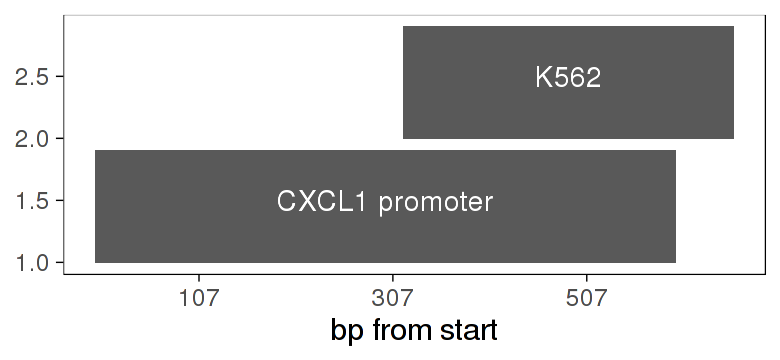

In [145]:
this_gene_symbol <- "CXCL1"

this_prom <- unique(prom_ranges[prom_ranges$gene_symbol %in% c(this_gene_symbol)])

this_gene <- gene_ranges[gene_ranges$gene_symbol %in% c(this_gene_symbol)]

x <- suppressWarnings(findOverlaps(
  query = this_prom,
  subject = cux1_peaks[unique(subjectHits(cux1_both))]
))
this_peaks <- cux1_peaks[unique(subjectHits(cux1_both))][subjectHits(x)]

file_to_cell <- c(
  "ENCFF903AOD.bed.gz" = "GM12878",
  "ENCFF688YAV.bed.gz" = "K562",
  "ENCFF022FYX.bed.gz" = "MCF-7"
)

d <- rbind(
#   data.frame(
#     chrom = as.character(seqnames(this_gene)),
#     start = start(this_gene),
#     end = end(this_gene),
#     strand = as.character(strand(this_gene)),
#     name = as.character(this_gene$gene_symbol)
#   ),
  data.frame(
    chrom = as.character(seqnames(this_prom)),
    start = start(this_prom),
    end = end(this_prom),
    strand = as.character(strand(this_prom)),
    name = paste(as.character(this_prom$gene_symbol), "promoter")
  ),
  data.frame(
    chrom = seqnames(this_peaks),
    start = start(this_peaks),
    end = end(this_peaks),
    strand = as.character(strand(this_peaks)),
    name = file_to_cell[this_peaks$file]
  )
)
d$bin <- disjointBins(IRanges(d$start, d$end))

d

ggplot(d) +
geom_rect(
  mapping = aes(
    xmin = start, xmax = end,
    ymin = bin, ymax = bin + 0.9
  )
) +
geom_text(
  mapping = aes(
    x = start + (end - start) / 2,
    y = bin + 0.5,
    label = name
  ),
  color = "white",
  size = 6
) +
# theme_bw() +
scale_x_continuous(labels = function(x) x - min(d$start)) +
labs(x = "bp from start", y = NULL)

## REMAP ChIP-seq peaks

In [ ]:
remap <- fread(
  "zcat /data/srlab/external-data/REMAP/remap2018_all_macs2_hg38_v1_2.bed.gz | grep -P '(CUX1|ELF3|STAT3|STAT4|NFKB)'",
  sep = "\t",
  header = FALSE
)
remap <- cbind(remap, stringr::str_split_fixed(remap$V4, "\\.", 3))

In [ ]:
colnames(remap) <- c(
  "chrom", "start", "end",
  "info", "V5", "V6",
  "start2", "end2", "color",
  "experiment", "protein", "celltype"
)
head(remap)

In [ ]:
table(remap$protein)

In [ ]:
table(table(remap$color))

In [ ]:
table(remap$experiment, remap$protein)

In [ ]:
remap_ranges <- GRanges(
  seqnames = remap$chrom,
  ranges = IRanges(
    start = remap$start,
    end = remap$end
  ),
  experiment = remap$experiment,
  protein = remap$protein,
  celltype = remap$celltype
)
remap_ranges

In [ ]:
f1 <- findOverlaps(query = remap_ranges, subject = prom_ranges)
prom_hits <- prom_ranges[subjectHits(f1)]

prom_hits$protein    <- remap_ranges[queryHits(f1)]$protein
prom_hits$experiment <- remap_ranges[queryHits(f1)]$experiment
prom_hits$celltype   <- remap_ranges[queryHits(f1)]$celltype

prom_hits

In [ ]:
prom_hits[prom_hits$gene_symbol %in% these_genes & prom_hits$protein %in% c("CUX1"),]

In [ ]:
data.frame(
  gene_symbol = prom_hits$gene_symbol,
  protein = prom_hits$protein,
  gene_id = prom_hits$gene_id
) %>%
group_by(protein) %>%
summarise(targets = length(unique(gene_symbol)))

In [ ]:
x <- dcast(
  data = data.frame(
    gene_symbol = prom_hits$gene_symbol,
    protein = prom_hits$protein,
    gene_id = prom_hits$gene_id
  ),
  formula = gene_symbol ~ protein,
  value.var = 'gene_id',
  fun.aggregate = length
)
x <- x[!is.na(x$gene_symbol),]
rownames(x) <- x$gene_symbol
x$gene_symbol <- NULL
x <- as.matrix(x)

In [ ]:
these_genes <- c(
  "CXCL1", "CXCL2", "CXCL3",
  "CXCL5", "CXCL6", "CXCL8",
  "CXCL10", "CCL20", "CCL5",
  "CCL2", "IL6", "CSF2",
  "CSF3", "NFKBIZ", "ELF3",
  "IL23A", "PTGS2", "G0S2",
  "MMP3", "MMP1", "TNFAIP2",
  "TNFAIP6"
)
length(these_genes)

length(intersect(these_genes, rownames(x)))

In [ ]:
chip <- (x[intersect(these_genes, rownames(x)),] > 0) + 0
chip_order <- seriate(chip, method = "BEA_TSP")
chip <- chip[chip_order[[1]], chip_order[[2]]]

In [ ]:
chip %>%
melt() %>%
ggplot(aes(Var2, Var1, fill = value)) +
geom_tile() +
theme_minimal()

### Nearest ChIP-seq peak

In [32]:
# Get the promoter for a particular gene
# this_gene <- "TNFRSF1A"
this_gene <- "CXCL2"
this_prom <- prom_ranges[which(prom_ranges$gene_symbol == this_gene)]
this_prom

GRanges object with 1 range and 2 metadata columns:
       seqnames               ranges strand |     gene_id gene_symbol
          <Rle>            <IRanges>  <Rle> | <character> <character>
  2920     chr4 [74099194, 74099793]      - |        2920       CXCL2
  -------
  seqinfo: 455 sequences (1 circular) from hg38 genome

In [33]:
remap_ranges[nearest(this_prom, remap_ranges)]

ERROR: Error in eval(expr, envir, enclos): object 'remap_ranges' not found
